# Описание данных

Данные представляют собой 21 000 фотографий, собранных участниками проекта. На каждой из фотографии человек показывает 1, 2, 3 , 4, 5, 6, 7, 8. 9 или 10 пальцев

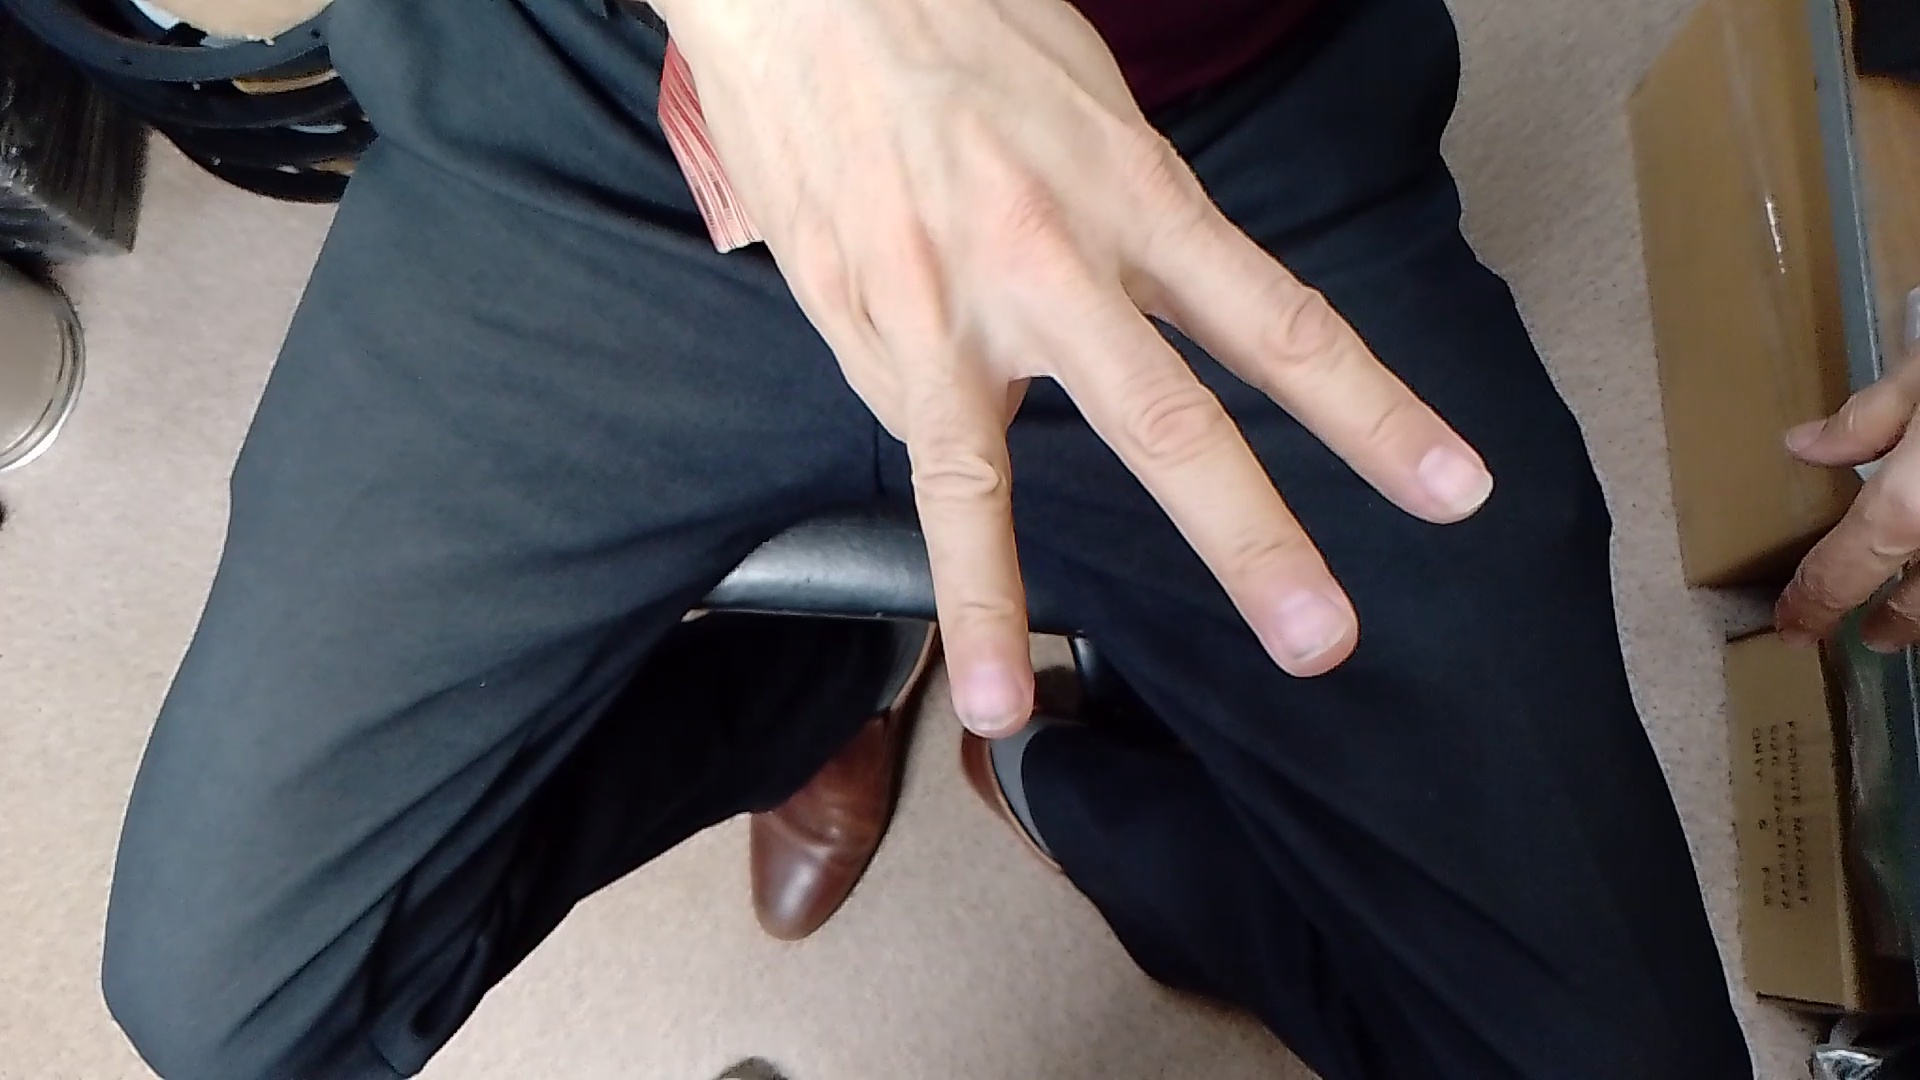

In [4]:
from PIL import Image
img = Image.open('Video to frames/10class/4018_2.jpg')
img

# Загрузка и обработка данных

Загрузка необходимых библиотек

In [1]:
import concurrent.futures
import os
from PIL import Image
import numpy as np
import os
import sys
from IPython.display import clear_output

Превращение фотографий 1920х1080 в массив (21633,270,480,3) и метки класса (21633, 10)

In [3]:
dim1 = 270
dim2 = 480

pctr_list = os.listdir('Video to frames/10class')

def one_hot_encode_label(image_name, num_classes=10):
    label = int(image_name.split('_')[1].split('.')[0])
    one_hot = np.zeros(num_classes, dtype=np.uint8)
    one_hot[label] = 1
    return one_hot

def preprocess_image(img):
    path = f'Video to frames/10class/{img}'

    img_X = Image.open(path).resize((dim2, dim1))
    data_X = np.array(img_X).astype(np.uint8)

    one_hot_label = one_hot_encode_label(img)

    return data_X, one_hot_label

X_list, Y_list = [], []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(preprocess_image, pctr_list)

    for i, (data_X, one_hot_label) in enumerate(results):
        Y_list.append(one_hot_label)
        X_list.append(data_X)
        print(f'{i+1} from {len(pctr_list)}', end='\r')
        clear_output(wait=True)
        
X, Y = np.array(X_list), np.array(Y_list)

# Постановка задачи

Наша задача - создать модель, которая по фотографии или в реальном времени (в видео-потоке) определяет, сколько пальцев показывает человек

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import numpy as np
import os
from keras.losses import binary_crossentropy
import sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import Metric

In [6]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

@tf.function
def f1_score(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))

input_shape = (270, 480, 3)

# Define the input tensor
inputs = layers.Input(shape=input_shape)

# Define the CNN architecture
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)

outputs = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])

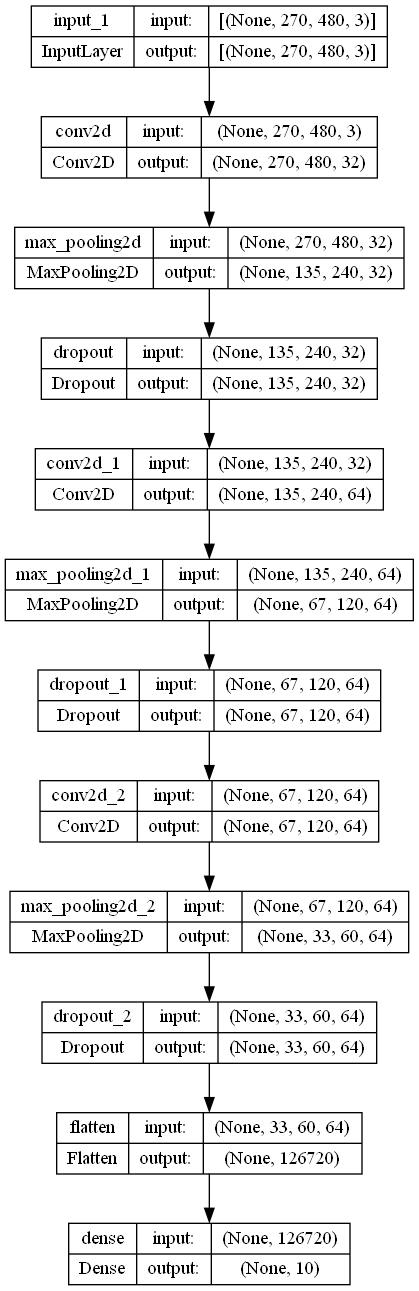

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Обучение модели

In [9]:
from keras.callbacks import EarlyStopping
patience = 10
early_stopping = EarlyStopping(monitor='val_f1_score', restore_best_weights = True, min_delta=0.0001, patience= patience, verbose = 1, mode = 'max')

In [ ]:
history = model.fit(X, Y, epochs = 500, validation_split = 0.2, batch_size = 2, callbacks=[early_stopping])

In [ ]:
model.save('10fingers.h5')

# Загрузка и проверка модели

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

@tf.function
def f1_score(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))

tf.keras.utils.get_custom_objects().update({'f1_score': f1_score})

# Load the model
model = tf.keras.models.load_model('10class_6.h5', custom_objects={'f1_score': f1_score})

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score])

In [3]:
from PIL import Image
import numpy as np

img = Image.open('Video to frames/10class/5_0.jpg').resize((480, 270))
img = np.array(img)
model.predict(img.reshape((1,270,480,3)))

1/1 [==============================] - 0s 174ms/step


array([[0.58601093, 0.0942035 , 0.04436228, 0.04243238, 0.07633612,
        0.02367443, 0.03010499, 0.03183629, 0.02602239, 0.04501668]],
      dtype=float32)

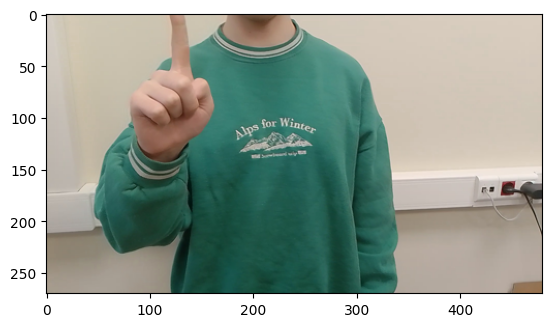

In [6]:
import matplotlib.pyplot as plt
plt.imshow(img)

Как мы видим, модель считает, что наиболее вероятный класс - 0, т.е. человек показывает 1 палец на фотографии